In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import dataframe_image as dfi
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from tqdm.notebook import tqdm

tqdm.monitor_interval = 0


# Die beste Gemeinde des Kantons Graubünden

Gewählte Gemeinde: Furna
Nachbars Gemeinden (alphabetisch): Flims und Fürstenau

## Quellen

Ich habe die folgenden Quellen verwendet:

- Q1: [Gemeinde Codes Graubünden](https://www.gr.ch/DE/institutionen/verwaltung/dvs/alg/Dokumente%20Geoinformation/AV_HS_02_DE_Die_Gemeinden_des_Kantons_Graub%C3%BCnden.pdf)
- Q2: [Regional Portraits](https://www.bfs.admin.ch/bfs/de/home/statistiken/regionalstatistik/regionale-portraets-kennzahlen/gemeinden/daten-erlaeuterungen.assetdetail.15864450.html)
- Q3: [Verkehrsunfälle Kanton Graubünden 2023](https://www.gr.ch/DE/institutionen/verwaltung/djsg/kapo/service/statistik/Documents/VU%20Statistik%202022.pdf)
- Q4: [Standard nomenclature (NOAS04) by district and municipality, in hectares](https://www.pxweb.bfs.admin.ch/pxweb/en/px-x-0202020000_102/-/px-x-0202020000_102.px/)
- Q5: [Wikipedia: Gemeinden des Kantons Graubünden](https://de.wikipedia.org/wiki/Gemeinden_des_Kantons_Graub%C3%BCnden)

Für jede Quelle habe ich ein entsprechendes Script erstellt welches die relevanten Daten aus der Quelle extrahiert. Dateien aus den Quellen welche heruntergeladen werden können 
(.pdf, .xlsx) sind unter dem Dateipfad `./data/raw` abgelegt. Jedes Script speichert die aufbereiteten Daten in einer .csv Datei unter `./data/scraped`. Um die Skripts erneut
auszuführen, kann die Konstante `RUN_SCRIPTS` auf `True` gesetzt werden.


In [2]:
RUN_SCRIPTS = False
if RUN_SCRIPTS:
    # zusätzliche dependencies der Scripts
    import pdfplumber
    import pyjstat
    import openpyxl
    from playwright.sync_api import sync_playwright
    from bs4 import BeautifulSoup
    
    !cd scrape && python extract-codes.py
    !cd scrape && python extract-regionalportraits.py
    !cd scrape && python extract-accidents.py
    !cd scrape && python fetch-districts.py
    !cd scrape && python scrape-wikipedia.py
else:
    print("scripts did not run; change constant RUN_SCRIPTS to rerun all scripts.")


scripts did not run; change constant RUN_SCRIPTS to rerun all scripts.


## Kriterien

Das Ranking der Gemeinden basiert auf 5 von mir erstellten Kriterien. Jede Gemeinde erhält bei jedem Kriterium einen Score zwischen 0 und 100. 
Später werden alle Scores verwendet, um einen gesamthaften Score zu berechnen. Die Funktion `plot_distribution` wird verwendet, um die Verteilung 
der Scores zu visualisieren.

In den folgenden Abschnitten beschreibe ich jedes Kriterium kurz und bereite die dafür benötigten Daten vor.


In [3]:
def plot_distribution(series, titel, x_label, y_label, color):
    """
    Plottet die Verteilung einer Serie als Histogramm mit 30 bins.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(series, bins=30, kde=True, color=color, edgecolor="black")
    plt.title(titel)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()


### Kriterium 1: Durchschnittliche Waldfläche pro Person

Verwendete Quellen: Q1, Q2

Im Kanton Graubünden ist es uns sehr wichtig, dass genügend Waldfläche für alle Bewohner vorhanden ist. Deshalb möchte ich
in meiner Rangliste Gemeinden bevorzugen, die eine grössere Waldfläche pro Person haben. 

Um die Waldfläche pro Person zu berechnen, multipliziere ich die Gesamtfläche der Gemeinde mit dem Anteil der Waldfläche an der Gesamtfläche
anschliessend teile ich das Resultat durch die Anzahl der Einwohner.


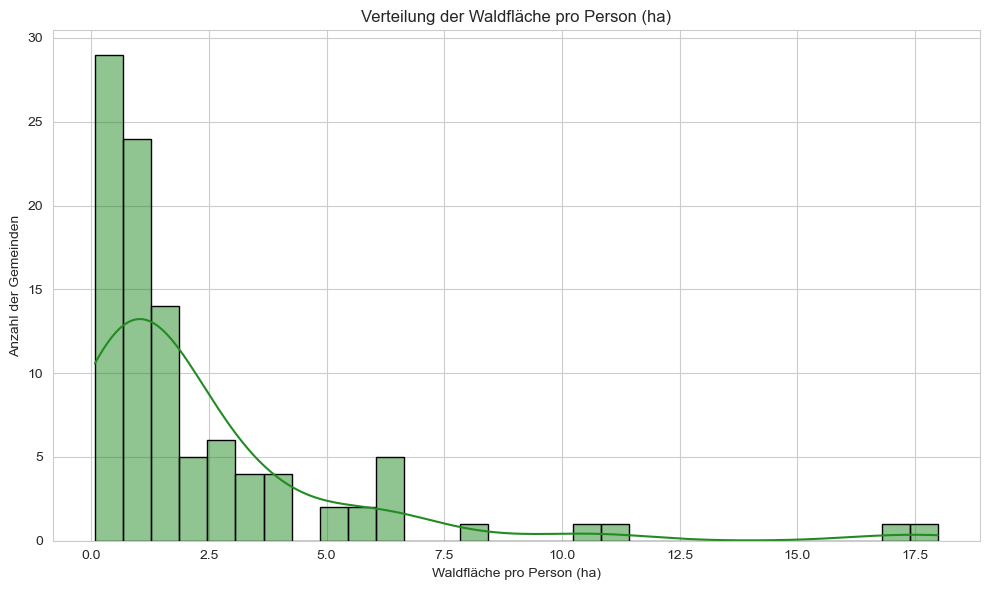

In [4]:
df_regio = pd.read_csv("./data/scraped/regionalportraits.csv")
df_regio = df_regio.sort_values(by="Gemeinde")

df_regio["Forest_area"] = df_regio["Total_Area_km2"] * df_regio["Forest_Vegetation_pct"]

# Berechne nun die durchschnittliche Waldfläche pro Person (in Hektaren)
df_regio["forest_area_per_person"] = df_regio["Forest_area"] / df_regio["Population"]

plot_distribution(df_regio["forest_area_per_person"], 
                  "Verteilung der Waldfläche pro Person (ha)", 
                  "Waldfläche pro Person (ha)",
                  "Anzahl der Gemeinden",
                  "forestgreen")


### Kriterium 2: Familienfreundliche Gemeinden

Verwendete Quellen: Q1, Q2

In meiner Rangliste möchte ich Gemeinden bevorzugen, in denen durchschnittlich grössere Haushalte mit einem höheren Anteil an Kindern und 
Jugendlichen vorhanden sind und die damit Familienfreundlicher sind.

Um die Familienfreundlichkeit zu berechnen, teile ich zuerst die Einwohnerzahl jeder Gemeinde durch die Anzahl der Haushalte, um die 
durchschnittliche Haushaltsgrösse zu erhalten. Anschliessend multipliziere ich dieses Resultat mit dem Anteil der Bevölkerung im Alter von 
0 bis 19 Jahren. Somit bevorzuge ich Gemeinden mit grossen Haushalten und vielen jungen Einwohnern.


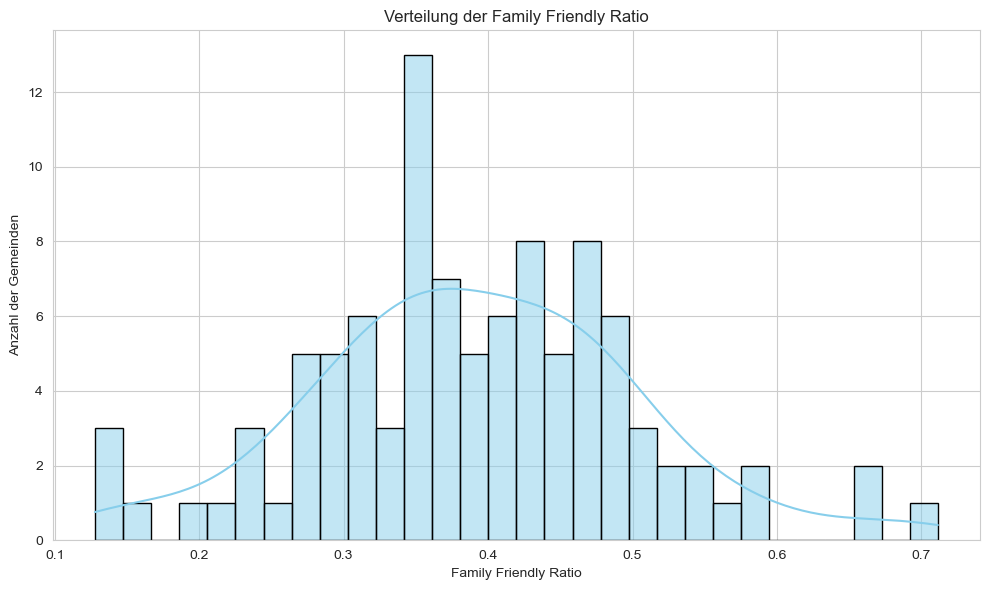

In [5]:
# Berechnet wie viele Personen im Durchschnitt in einem Haushalt leben
df_regio["Avg_Household_Size"] = df_regio["Population"] / df_regio["Households"]
# Berechnet wie Familienfreundlich eine Gemeinde ist anhand der Haushaltsgrösse und dem Anteil der Bevölkerung im Alter von 0-19 Jahren
df_regio["family_friendly"] = df_regio["Avg_Household_Size"] * (df_regio["Age_0_19"] / 100)

plot_distribution(df_regio["family_friendly"],
                  "Verteilung der Family Friendly Ratio",
                  "Family Friendly Ratio",
                  "Anzahl der Gemeinden",
                  "skyblue")


### Kriterium 3: Wikipedia Artikel

Verwendete Quellen: Q5

Im Kanton Graubünden möchten wir Gemeinden bevorzugen, die bekannt und für die Öffentlichkeit besonders interessant sind. Wikipedia 
bietet hier einen guten Indikator für den Bekanntheitsgrad einer Gemeinde.

Um die Sichtbarkeit und Bekanntheit einer Gemeinde abzuschätzen, verwende ich deshalb die Länge des Wikipedia-Artikels als Indikator. 
Dazu messe ich die Anzahl Zeichen im Wikipedia-Artikel zu jeder Gemeinde. Gemeinden mit einem längeren Wikipedia-Artikel sind in der 
Regel besser dokumentiert und daher von höherer öffentlicher Relevanz.


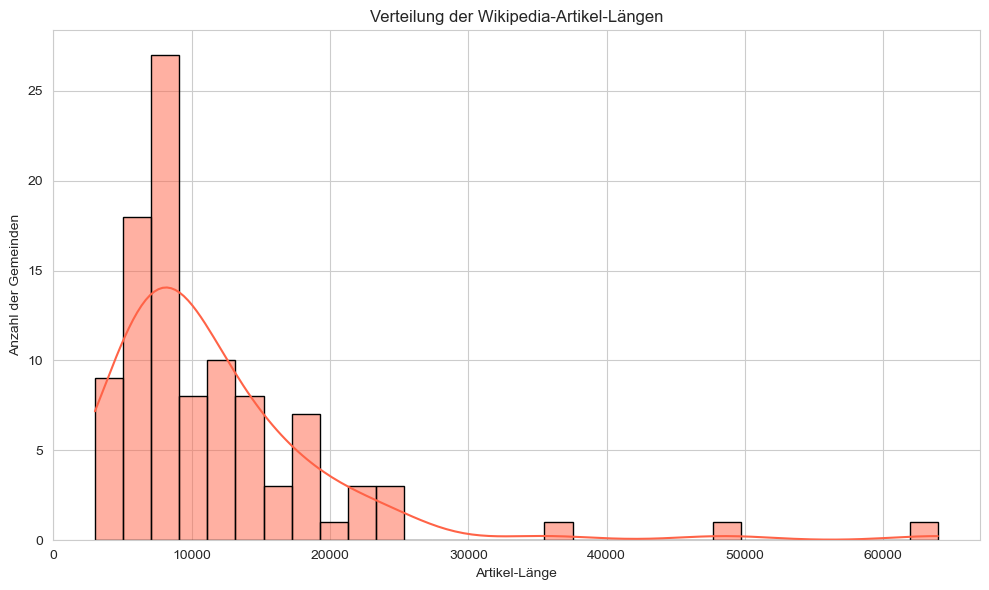

In [6]:
df_wiki = pd.read_csv("./data/scraped/wikipedia-length.csv")
df_wiki = df_wiki.sort_values(by="Gemeinde")

plot_distribution(df_wiki["Artikel_Laenge"],
                  "Verteilung der Wikipedia-Artikel-Längen",
                  "Artikel-Länge",
                  "Anzahl der Gemeinden",
                  "tomato")


### Kriterium 4: Verkehrsunfälle

Verwendete Quellen: Q3

Im Kanton Graubünden legen wir grossen Wert auf die Verkehrssicherheit unserer Gemeinden. Deshalb bevorzuge ich Gemeinden, 
in denen möglichst wenige und weniger schwere Verkehrsunfälle stattfinden.

Um die Verkehrssicherheit objektiv zu bewerten, berechne ich einen sogenannten **Accident Score**. Dabei erhält jeder 
Unfalltyp ein unterschiedliches Gewicht, abhängig von der Schwere seiner Folgen:

- **Sachschäden**: 1 Punkt
- **Unfälle mit Personenschäden**: 2 Punkte
- **Erheblich Verletzte**: 5 Punkte
- **Schwerverletzte**: 10 Punkte
- **Lebensbedrohlich Verletzte**: 15 Punkte
- **Getötete**: 20 Punkte

Anschliessend summiere ich diese gewichteten Unfallzahlen für jede Gemeinde. Gemeinden mit einem niedrigeren Accident Score 
gelten somit als sicherer und werden in der Rangliste bevorzugt.


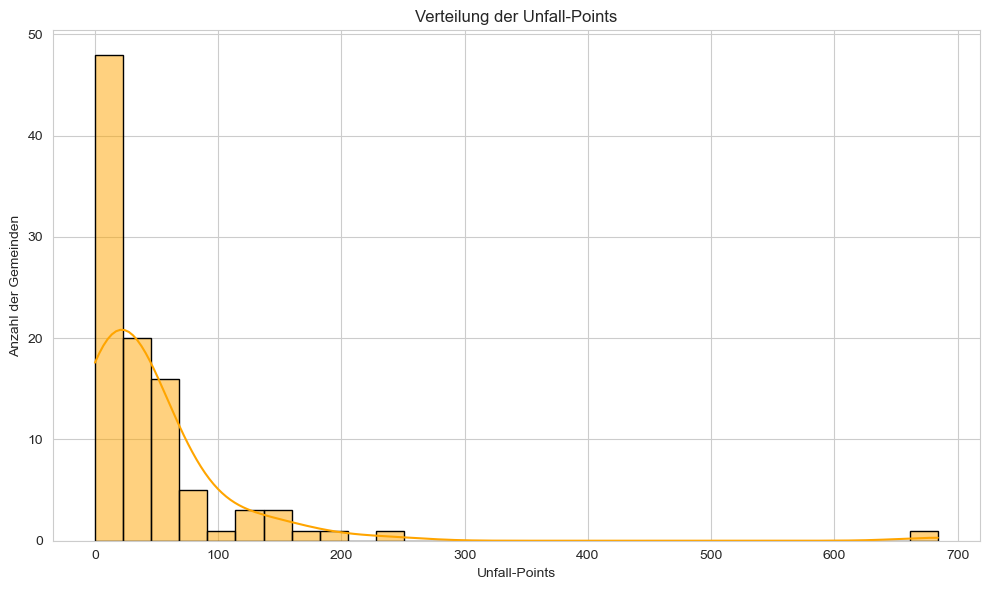

In [7]:
df_accidents = pd.read_csv("./data/scraped/accidents.csv")
df_accidents = df_accidents.sort_values(by="Gemeinde")

multiplier_sach = 1
multiplier_person = 2
multiplier_getoetete = 20
multiplier_schwer = 10
multiplier_lebensbedrohlich = 15
multiplier_erheblich = 5

# Berechnet den Unfall-Points für jede Gemeinde anhand der Unfallstatistik
df_accidents["accident_points"] = (
        df_accidents["Unfälle-mit-Sachschaden"] * multiplier_sach +
        df_accidents["Unfälle-mit-Personenschaden"] * multiplier_person +
        df_accidents["Getötete"] * multiplier_getoetete +
        df_accidents["Schwerverletzte"] * multiplier_schwer +
        df_accidents["Lebensbedrohlich-Verletzte"] * multiplier_lebensbedrohlich +
        df_accidents["Erheblich-Verletzte"] * multiplier_erheblich
)

plot_distribution(df_accidents["accident_points"],
                  "Verteilung der Unfall-Points",
                  "Unfall-Points",
                  "Anzahl der Gemeinden",
                  "orange")


### Kriterium 5: Strassenfläche

Verwendete Quellen: Q1, Q5

Im Kanton Graubünden legen wir Wert darauf, dass Gemeinden über eine gut ausgebaute Strasseninfrastruktur verfügen,
 die ausreichend Platz für Verkehrsteilnehmer bietet.

Gemeinden mit einer grösseren Strassenfläche bieten mehr Bewegungsfreiheit und Komfort im Strassenverkehr und erhalten daher 
eine bessere Bewertung.


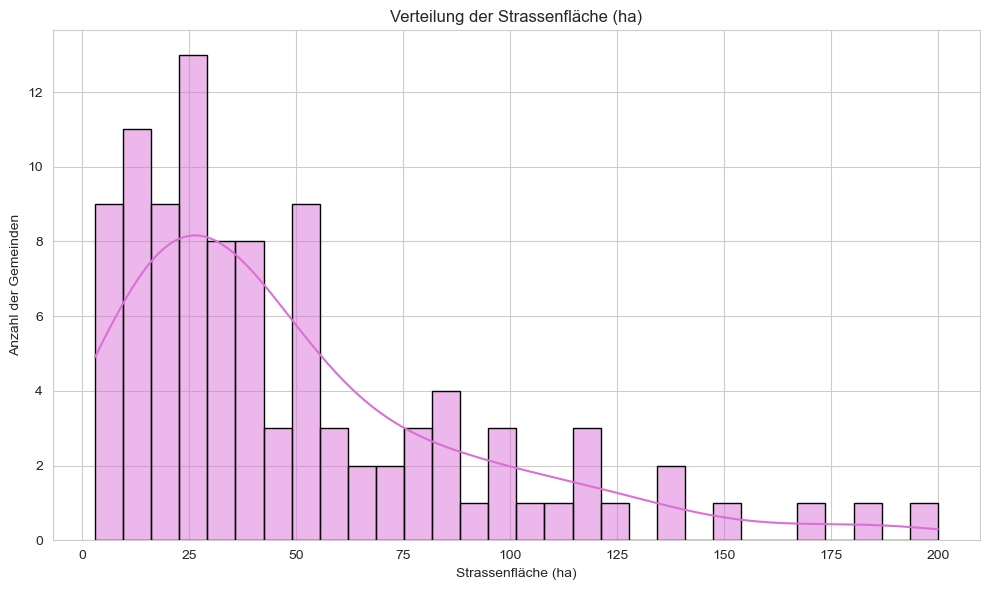

In [8]:
df_streets = pd.read_csv("./data/scraped/streets.csv")
df_streets = df_streets.sort_values(by="Gemeinde")

plot_distribution(df_streets["Strassenflaeche-Hektar"],
                  "Verteilung der Strassenfläche (ha)",
                  "Strassenfläche (ha)",
                  "Anzahl der Gemeinden",
                  "orchid")


## Rangliste

Als Nächstes möchte ich jeder Geimeinde anhand der verschiedenen Scores einen Final-Score zuweisen und die Gemeinden dann entsprechend in einer Rangliste sortieren.

Ich habe mir selber das Ziel gesetzt keine weiteren Kriterien zu verwenden und die Rohdaten nicht zu verändern. Stattdessen wende ich unterschiedliche
Transformationen auf die Scores an und setze die Gewichte so, dass ich mein gewünschtes Ergebnis erhalte. Ich manipuliere das Ergebnis also durch die
geschickte Wahl von Transformationen und Gewichten.

### Transformationen

Ich habe folgende Transformationen verwendet:

- Normalisierung
- Logarithmische Transformation
- Box-Cox Transformation
- Standardisierung
- Robust Scaling
- Yeo-Johnson Transformation
- Quantile Transformation

Wichtig ist anzumerken, dass alle diese Transformationen zwar die Verteilung der Daten verändern, jedoch die Reihenfolge der Gemeinden in den einzelnen Kriterien.


In [9]:
def normalize(series):
    """
    Normalisiert eine Serie auf den Bereich 0-100
    """
    return 100 * (series - series.min()) / (series.max() - series.min())

def log_and_normalize(series):
    """
    Wendet eine logarithmische Transformation auf die Serie an und normalisiert sie anschliessend.
    """
    return normalize(np.log1p(series))

def boxcox_and_normalize(series):
    """
    Wendet eine Box-Cox Transformation auf die Serie an und normalisiert sie anschliessend.
    """
    if series.min() <= 0:
        series = series + abs(series.min()) + 1e-6
    transformed, lam = boxcox(series.values)
    return normalize(pd.Series(transformed))

def standardize_and_normalize(series):
    """
    Standardisiert die Serie und normalisiert sie anschliessend.
    """
    standardized = (series - series.mean()) / series.std()
    return normalize(standardized)

def robust_scale_and_normalize(series):
    """
    Wendet eine robuste Skalierung auf die Serie an und normalisiert sie anschliessend.
    """
    robust_scaled = (series - series.median()) / (series.quantile(0.75) - series.quantile(0.25))
    return normalize(robust_scaled)

def yeo_johnson_and_normalize(series):
    """
    Wendet eine Yeo-Johnson Transformation auf die Serie an und normalisiert sie anschliessend.
    """
    pt = PowerTransformer(method="yeo-johnson")
    transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
    return normalize(pd.Series(transformed))

def quantile_transform_and_normalize(series):
    """
    Wendet eine Quantile Transformation auf die Serie an und normalisiert sie anschliessend.
    """
    n_quantiles = min(1000, len(series))
    qt = QuantileTransformer(n_quantiles=n_quantiles, output_distribution="normal")
    transformed = qt.fit_transform(series.values.reshape(-1, 1)).flatten()
    return normalize(pd.Series(transformed))

scores = [
    "forest_score",
    "family_score",
    "wiki_score",
    "accident_score",
    "street_score"
]

transformation_candidates = [
    normalize,
    log_and_normalize,
    boxcox_and_normalize,
    standardize_and_normalize,
    robust_scale_and_normalize,
    yeo_johnson_and_normalize,
    quantile_transform_and_normalize
]

def calculate_scores(df, trans_funcs):
    df_merged = df.merge(df_regio[["Gemeinde", "forest_area_per_person", "family_friendly"]], on="Gemeinde")
    df_merged = df_merged.merge(df_wiki[["Gemeinde", "Artikel_Laenge"]], on="Gemeinde")
    df_merged = df_merged.merge(df_accidents[["Gemeinde", "accident_points"]], on="Gemeinde")
    df_merged = df_merged.merge(df_streets[["Gemeinde", "Strassenflaeche-Hektar"]], on="Gemeinde")
    
    df_merged["forest_score"] = trans_funcs["forest_score"](df_merged["forest_area_per_person"])
    df_merged["family_score"] = trans_funcs["family_score"](df_merged["family_friendly"])
    df_merged["wiki_score"] = trans_funcs["wiki_score"](df_merged["Artikel_Laenge"])
    df_merged["accident_score"] = 100 - trans_funcs["accident_score"](df_merged["accident_points"])
    df_merged["street_score"] = trans_funcs["street_score"](df_merged["Strassenflaeche-Hektar"])
    
    return df_merged[["Gemeinde", "forest_score", "family_score", "wiki_score", "accident_score", "street_score"]]


### Gewichte

Jeder der 5 Scores kann einen Wert zwischen 0 und 100 annehmen. Um den finalen Score zu berechnen, erhält jeder der Scores eine Gewichtung. Alle Gewichtungen aufsummiert ergeben 1.
Um den Finalen Score zu berechnen, multipliziere ich die Scores mit den Gewichtungen und summiere sie auf.

Wie ich die hier eingetragenen Gewichtungen gefunden habe, ist im nächsten Abschnitt beschrieben.


In [10]:
best_weights = {
    "forest_score": 0.408760042235608,
    "family_score": 0.17236401143071217,
    "wiki_score": 0.2625593204015222,
    "accident_score": 0.018534212378060442,
    "street_score": 0.1377824135540972
}

def calculate_final_score(df, weights):
    df["final_score"] = (
        df["forest_score"] * weights["forest_score"] +
        df["family_score"] * weights["family_score"] +
        df["wiki_score"] * weights["wiki_score"] +
        df["accident_score"] * weights["accident_score"] +
        df["street_score"] * weights["street_score"]
    )
    df["final_score"] = df["final_score"].round(1)
    return df.sort_values(by="final_score", ascending=False).reset_index(drop=True)


### Beste Konfiguration finden

Ziel ist es eine Konfiguration aus Transformationen und Gewichten zu finden, bei der die Gemeinde Furna auf Platz 1 liegt und die Gemeinden Flims und Fürstenau möglichst schlecht abschneiden.
Zu Beginn habe ich versucht eine solche Konfig manuell zu finden, jedoch habe ich schnell bemerkt, dass die Abhängigkeiten zwischen den Scores sehr komplex sind und es schwierig ist
eine gute Konfiguration zu finden.

Deshalb habe ich einen systematischen Ansatz gewählt. Ich habe eine Funktion geschrieben, die zufällige Konfigurationen aus Transformationen und Gewichtungen generiert und die Rangpositionen der Gemeinden
berechnet. Es wird die beste gefundene Konfiguration gespeichert und am Ende ausgegeben.

Mit dem Parameter n_iter kann die Anzahl der generierten Konfigurationen angegeben werden. Um eine möglichst gute Konfiguration zu finden, habe ich insgesamt ca 1'000'000 Konfigurationen generiert
und die beste in den Parametern `best_weights` und `best_transformations` festgehalten.

Da dieser Vorgang viel Zeit in Anspruch nimmt, kann das Flag `CALCULATE_CONFIG` auf `False` gesetzt werden, um die bereits gefundenen besten Gewichtungen und Transformationen zu verwenden.


In [11]:
relevant_communities = ["Furna", "Flims", "Fürstenau"]

def random_transformations():
    """
    Wählt für jeden Score eine zufällige Transformation aus den Kandidaten aus und gibt die entsprechende Konfiguration zurück.
    """
    trans_funcs = {}
    for score in scores:
        chosen_func = np.random.choice(transformation_candidates)
        trans_funcs[score] = chosen_func
    return trans_funcs

def random_weights(keys, min_weight=0.01):
    """
    Wählt zufällige Gewichtungen für die gegebenen Keys aus. Die Summe der Gewichtungen beträgt 1 und jedes Gewicht ist mindestens min_weight.
    """
    k = len(keys)
    base = np.full(k, min_weight)
    remainder = 1 - k * min_weight

    rand = np.random.random(k)
    rand /= rand.sum()

    values = base + rand * remainder
    return dict(zip(keys, values))

def find_best_config(n_iter=10000):
    """
    Erstellt und evaluiert n_iter zufällige Konfigurationen und gibt die beste Konfiguration zurück.
    Die beste Konfiguration ist diejenige, bei der Furna auf Rang 1 liegt und die Summe der Ränge von Flims und Fürstenau maximal ist.
    """
    best_config = None
    best_objective = -1
    ranking_results = {community: [] for community in relevant_communities}

    for _ in tqdm(range(n_iter), desc="Konfigurationen Evaluieren"):
        df_base = df_regio[["Gemeinde"]].copy()
        
        # Wählt zufällige Transformationen und Gewichtungen und evaluiert die Konfiguration
        trans_funcs = random_transformations()
        df_base = calculate_scores(df_base, trans_funcs)

        new_weights = random_weights(best_weights.keys())
        df_base = calculate_final_score(df_base, new_weights)

        # Ermittelt die Ränge der relevanten Gemeinden
        furna_rank = df_base[df_base["Gemeinde"] == "Furna"].index[0] + 1
        flims_rank = df_base[df_base["Gemeinde"] == "Flims"].index[0] + 1
        fuerstenau_rank = df_base[df_base["Gemeinde"] == "Fürstenau"].index[0] + 1

        # Speichert die Konfiguration, wenn Furna auf Rang 1 liegt und sie besser ist als die bisher beste Konfiguration
        if furna_rank == 1:
            ranking_results["Furna"].append(furna_rank)
            ranking_results["Flims"].append(flims_rank)
            ranking_results["Fürstenau"].append(fuerstenau_rank)
            
            objective = flims_rank + fuerstenau_rank
            if objective > best_objective:
                best_objective = objective
                best_config = {
                    "weights": new_weights.copy(),
                    "transformations": {key: trans_funcs[key] for key in trans_funcs},
                    "objective": best_objective
                }

    if best_config is not None:
        print("Beste Konfiguration gefunden:")
        print("Gewichtungen:")
        print(best_config["weights"])
        print("Transformationen:")
        print(best_config["transformations"])
        print(f"Zielfunktionswert (Flims + Fürstenau Rang): {best_config['objective']:.2f}")
    else:
        print("Keine Konfiguration gefunden, bei der Furna auf Rang 1 liegt.")

    return best_config

# Steuert, ob eine neue Konfiguration berechnet werden soll oder die hardcoded Konfiguration verwendet werden soll
CALCULATE_CONFIG = True
if CALCULATE_CONFIG:
    calculated_config = find_best_config(n_iter=10_000)
else:
    calculated_config = None


Konfigurationen Evaluieren:   0%|          | 0/10000 [00:00<?, ?it/s]

Beste Konfiguration gefunden:
Gewichtungen:
{'forest_score': 0.3283711675651387, 'family_score': 0.37751952094278496, 'wiki_score': 0.010586675749002657, 'accident_score': 0.0642012005569403, 'street_score': 0.21932143518613353}
Transformationen:
{'forest_score': <function boxcox_and_normalize at 0x126a65a80>, 'family_score': <function yeo_johnson_and_normalize at 0x126a65c60>, 'wiki_score': <function quantile_transform_and_normalize at 0x126a65da0>, 'accident_score': <function quantile_transform_and_normalize at 0x126a65da0>, 'street_score': <function quantile_transform_and_normalize at 0x126a65da0>}
Zielfunktionswert (Flims + Fürstenau Rang): 192.00


### Transformationen auf die Scores anwenden

Nun wende ich die besten Transformationen auf die Scores an und gebe die Verteilungen der Scores aus.

,Gemeinde,forest_score,family_score,wiki_score,accident_score,street_score
0,Albula/Alvra,67.904918,39.546813,60.772578,42.146813,60.772578
1,Andeer,60.304288,55.915774,59.499646,44.185939,51.343539
2,Arosa,51.416545,24.165665,69.710148,40.500354,62.269034
3,Avers,67.286580,54.182848,53.096268,65.321363,46.123467
4,Bergün Filisur,78.204366,41.650720,37.160117,51.343539,56.109141
...,...,...,...,...,...,...
95,Vaz/Obervaz,36.005640,41.293778,68.044208,43.589912,59.499646
96,Zernez,79.773282,51.948754,54.683231,30.289852,61.738422
97,Zillis-Reischen,64.117206,49.437202,45.857864,58.921845,46.516467
98,Zizers,7.083764,60.138969,51.343539,39.227422,55.524358


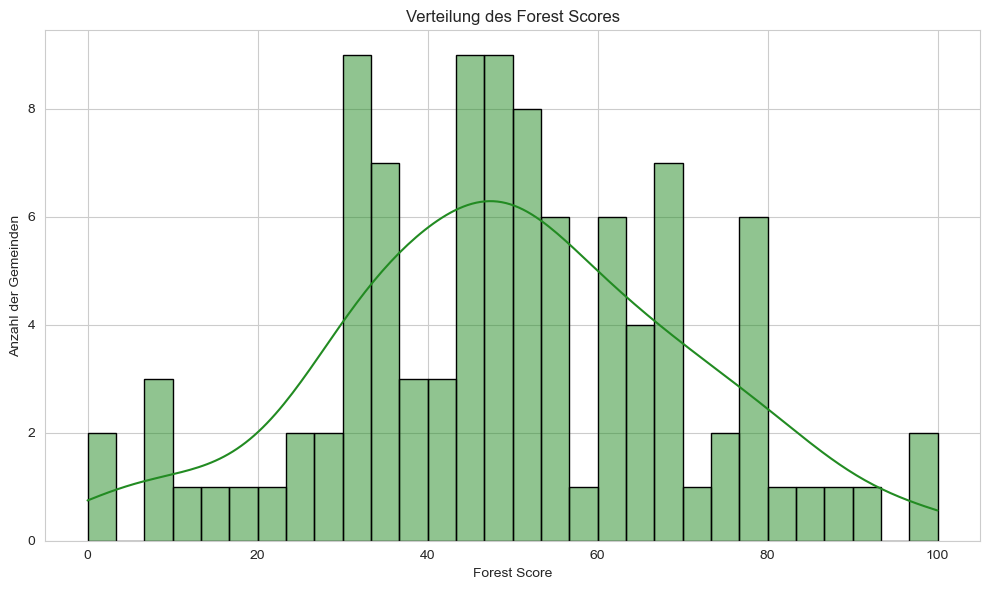

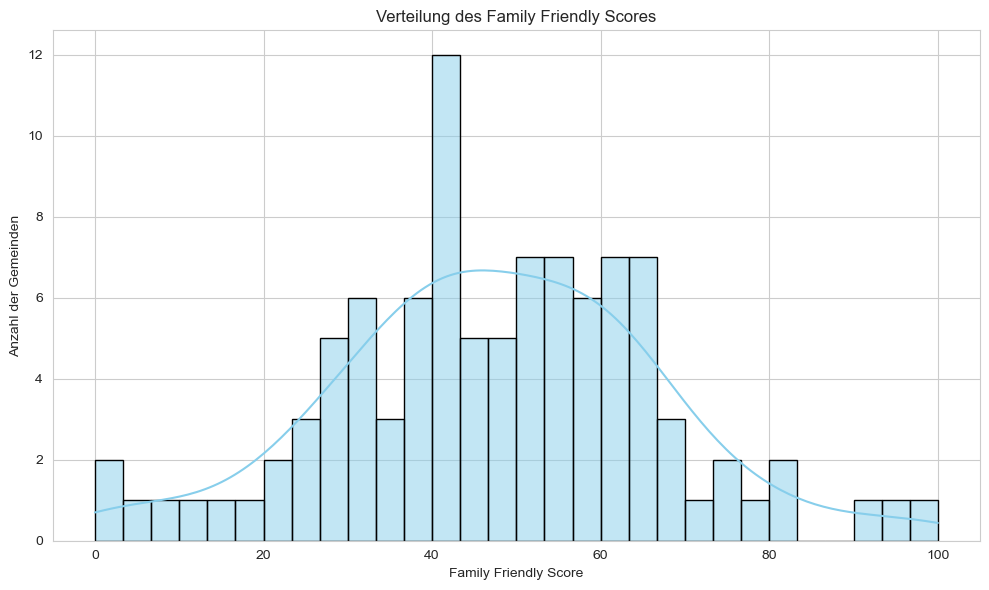

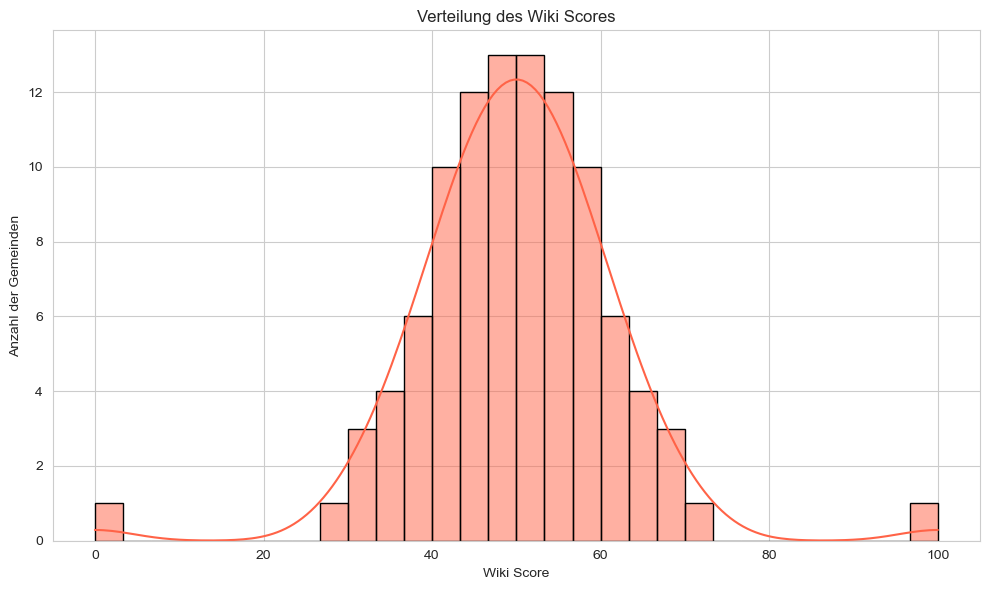

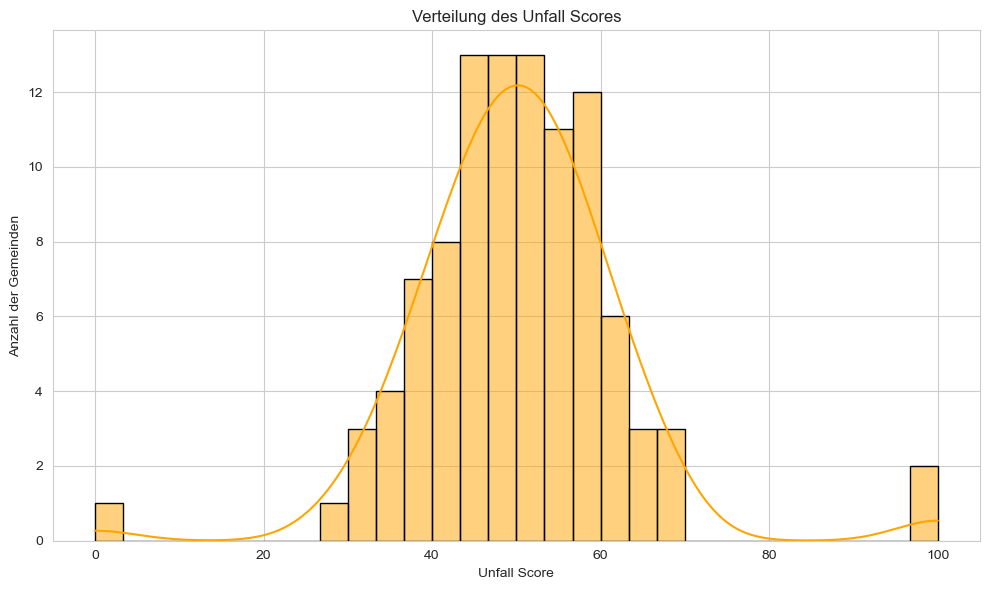

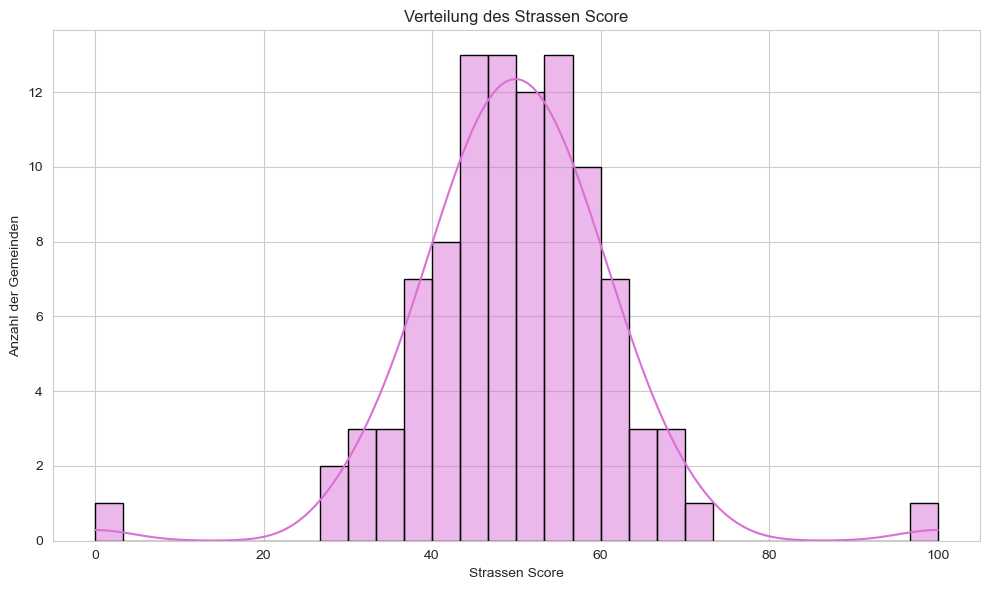

In [12]:
best_transformations = {
    "forest_score": log_and_normalize,
    "family_score": robust_scale_and_normalize,
    "wiki_score": normalize,
    "accident_score": boxcox_and_normalize,
    "street_score": quantile_transform_and_normalize
}

# Berechne die Scores für jede Gemeinde
df_rank = df_regio[["Gemeinde"]].copy()
if CALCULATE_CONFIG:
    df_rank = calculate_scores(df_rank, calculated_config["transformations"])
else:
    df_rank = calculate_scores(df_rank, best_transformations)

# Gibt die Scores aus
display(df_rank)

# Visualisiert die Verteilungen der Scores
plot_distribution(df_rank["forest_score"],
                  "Verteilung des Forest Scores",
                  "Forest Score",
                  "Anzahl der Gemeinden",
                  "forestgreen")

plot_distribution(df_rank["family_score"],
                  "Verteilung des Family Friendly Scores",
                  "Family Friendly Score",
                  "Anzahl der Gemeinden",
                  "skyblue")

plot_distribution(df_rank["wiki_score"],
                  "Verteilung des Wiki Scores",
                  "Wiki Score",
                  "Anzahl der Gemeinden",
                  "tomato")

plot_distribution(df_rank["accident_score"],
                  "Verteilung des Unfall Scores",
                  "Unfall Score",
                  "Anzahl der Gemeinden",
                  "orange")

plot_distribution(df_rank["street_score"],
                  "Verteilung des Strassen Score",
                  "Strassen Score",
                  "Anzahl der Gemeinden",
                  "orchid")


### Finalen Score berechnen

Jetzt berechne, verwende ich die zuvor erstellte Funktion zur berechnung des finalen Scores. Nachdem die Rangliste nach dem finalen Score
sortiert wurde, füge ich eine neue Spalte für den Rang ein.

Ich gebe die relevanten Gemeinden aus, um deren Positionen in der Rangliste zu überprüfen. Ausserdem plote ich die Verteilung der Ranks um
zu überprüfen ob die Rangliste "realistisch" aussieht.


,Gemeinde,forest_score,family_score,wiki_score,accident_score,street_score,final_score
0,Furna,80.160104,93.117447,41.263715,100.000000,42.646086,77.7
93,Flims,32.495773,29.027014,64.902917,48.656461,54.410938,37.4
97,Fürstenau,7.412654,60.710624,46.386144,56.717449,31.955792,36.5


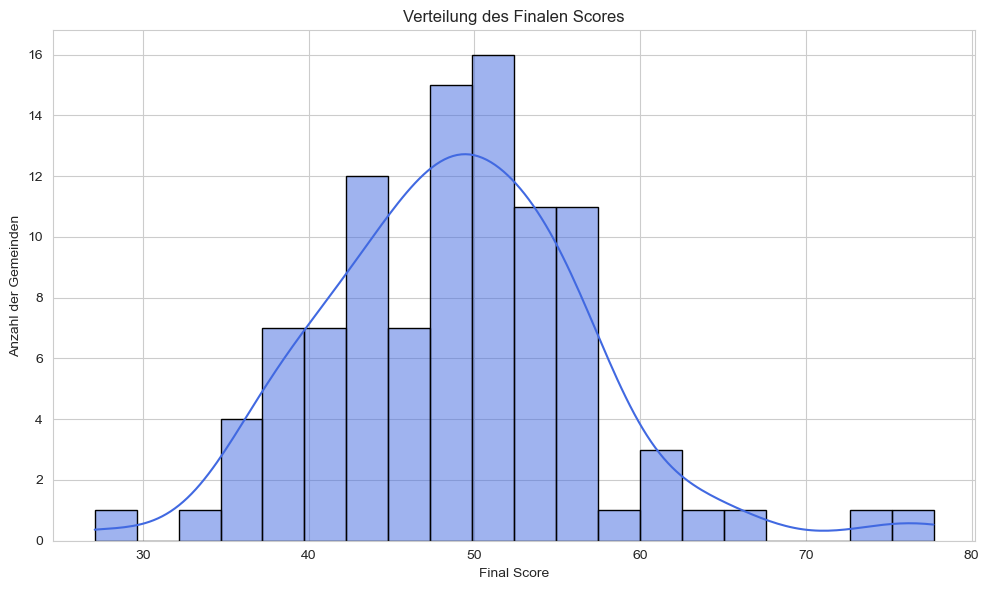

In [13]:
# Berechne den finalen Score für jede Gemeinde
if CALCULATE_CONFIG:
    df_rank = calculate_final_score(df_rank, calculated_config["weights"])
else:
    df_rank = calculate_final_score(df_rank, best_weights)

# Gibt die relevanten Gemeinden aus um das Ergebnis zu überprüfen
selected_df = df_rank[df_rank["Gemeinde"].isin(relevant_communities)]
display(selected_df)

# Fügt den Rang hinzu und speichert die Rangliste
df_rank.pop("Rank") if "Rank" in df_rank else None
df_rank.insert(0, "Rank", range(1, len(df_rank) + 1))
df_rank.to_csv("./data/ranking.csv", index=True)

# Visualisiert die Verteilung der Ränge um zu überprüfen ob diese realistisch aussehen
plt.figure(figsize=(10, 6))
sns.histplot(df_rank["final_score"], bins=20, kde=True, color="royalblue", edgecolor="black")
plt.title("Verteilung des Finalen Scores")
plt.xlabel("Final Score")
plt.ylabel("Anzahl der Gemeinden")
plt.tight_layout()
plt.show()


### Rangliste darstellen

Nun stelle ich die Rangliste der Gemeinden mit allen Scores und dem finalen Score dar. Die relevanten Gemeinden sind farblich hervorgehoben.

Falls die Rangliste nicht korrekt angezeigt wird, habe ich sie auch als png unter `./img/ranking.png` gespeichert.


In [14]:
df_display = df_rank.rename(columns={
    "forest_score":    "Forest Score",
    "family_score":    "Family Score",
    "wiki_score":      "Wiki Score",
    "accident_score":  "Accident Score",
    "street_score":    "Street Score",
    "final_score":     "Final Score"
}).copy()

def color_gemeinde(name):
    if name == "Furna":
        return "color: green; font-weight: bold"
    if name in ["Flims", "Fürstenau"]:
        return "color: red"
    return ""

# Wendet diverse Stylings auf die Rangliste an
styled_df = (
    df_display.style
    .use({"hide_index": True})
    .set_caption("🏆 Rangliste der Gemeinden 🏆")
    .format({
        "Rank":           "{:.0f}",
        "Forest Score":   "{:.1f}",
        "Family Score":   "{:.1f}",
        "Wiki Score":     "{:.1f}",
        "Accident Score": "{:.1f}",
        "Street Score":   "{:.1f}",
        "Final Score":    "{:.1f}"
    })
    .bar(subset=["Final Score"], color="#5fba7d")
    .background_gradient(subset=["Forest Score","Family Score","Wiki Score","Accident Score","Street Score"],
                         cmap="RdYlGn", vmin=0, vmax=100)
    .set_properties(**{"text-align": "center"})
    .map(color_gemeinde, subset=["Gemeinde"])
    .set_table_styles([
        {
            "selector": "caption",
            "props": [
                ("text-align", "center"),
                ("font-size", "200%"),
                ("font-weight", "bold"),
            ]
        },
        {
            "selector": "th",
            "props": [("text-align", "center"), ("font-size", "120%")]
        }
    ])
)

SAVE_RANKING = False
if SAVE_RANKING:
    dfi.export(styled_df, "./img/ranking.png", table_conversion="selenium")

display(styled_df)


Rank,Gemeinde,Forest Score,Family Score,Wiki Score,Accident Score,Street Score,Final Score
1,Furna,80.2,93.1,41.3,100.0,42.6,77.7
2,Sufers,79.3,94.0,44.8,52.3,43.4,74.9
3,Safiental,76.1,64.3,27.7,46.6,59.9,65.7
4,Flerden,40.1,100.0,43.6,68.0,41.3,64.8
5,Valsot,78.3,53.3,35.1,45.6,60.3,62.4
6,Zernez,79.8,51.9,54.7,30.3,61.7,61.9
7,Rongellen,61.8,74.6,35.9,60.8,33.2,60.0
8,Poschiavo,56.3,59.8,64.1,37.2,65.8,58.5
9,Bergün Filisur,78.2,41.7,37.2,51.3,56.1,57.4
10,Avers,67.3,54.2,53.1,65.3,46.1,57.4


## Visualisierungen für den Bericht

Für den Bericht erstelle ich jetzt einige Visualisierungen, die die Ergebnisse des Rankings zusammenfassen und Furna besonder gut darstellen

Die Visulisierungen werden als png Dateien in den Ordner `./img` gespeichert.


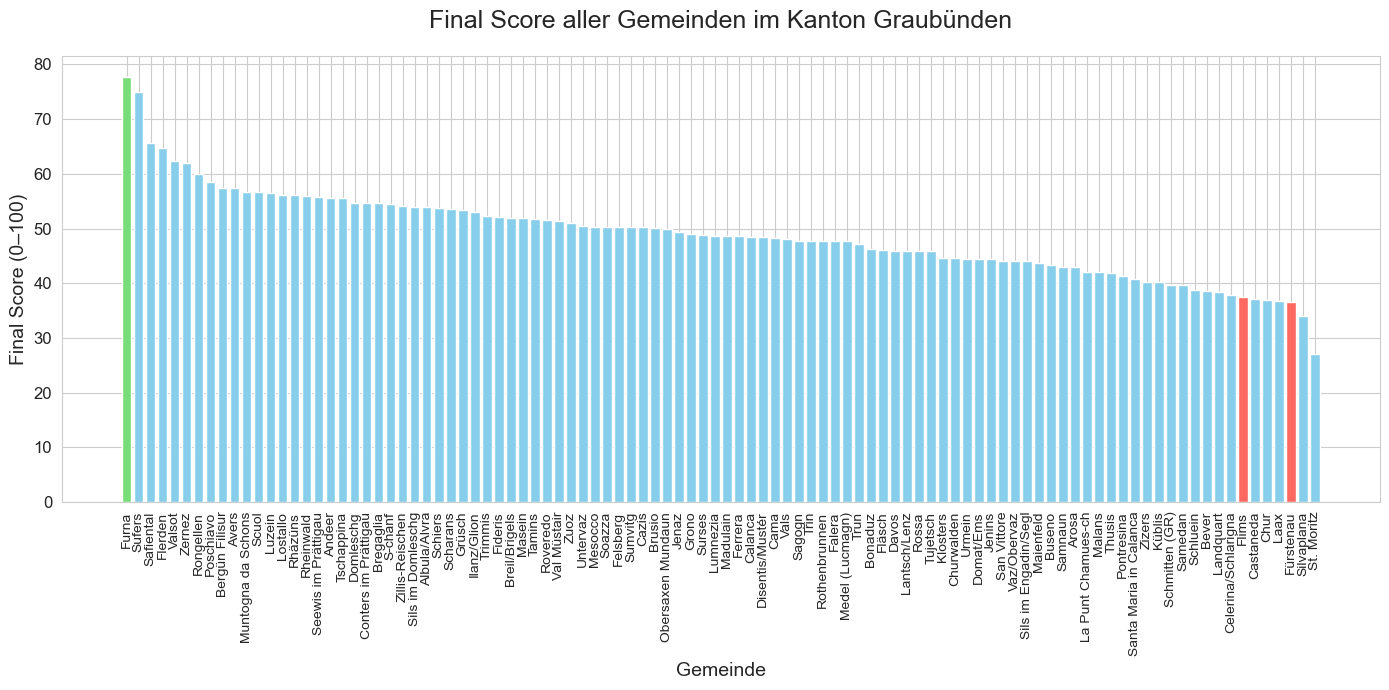

In [15]:
def get_color(gemeinde):
    """
    Hebt die relevanten Gemeinden farblich hervor.
    """
    if gemeinde == "Furna":
        return "#77dd77"
    elif gemeinde in ["Flims", "Fürstenau"]:
        return "#ff6961"
    else:
        return "skyblue"

colors = df_rank["Gemeinde"].apply(get_color)

# Visualisierung der Ränge
plt.figure(figsize=(14, 7))
plt.bar(df_rank["Gemeinde"], df_rank["final_score"], color=colors)
plt.title("Final Score aller Gemeinden im Kanton Graubünden", fontsize=18, pad=20)
plt.ylabel("Final Score (0–100)", fontsize=14)
plt.xlabel("Gemeinde", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("./img/final_score.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


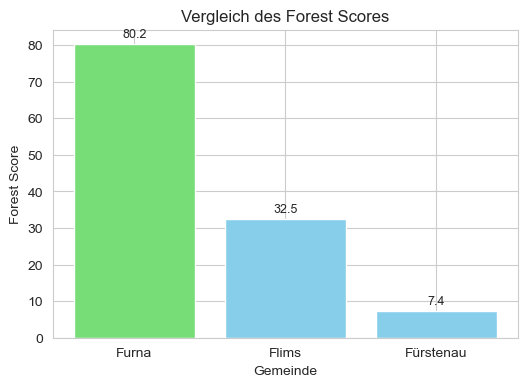

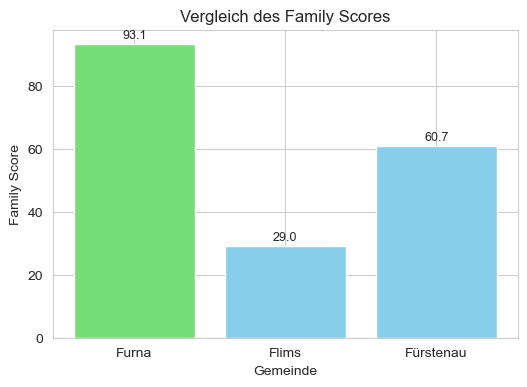

In [16]:
# Visualisierung für den Forest Score
plt.figure(figsize=(6, 4))
results = df_rank.set_index("Gemeinde").loc[relevant_communities, "forest_score"]
plt.bar(results.index, results.values, color=colors)
plt.title("Vergleich des Forest Scores")
plt.ylabel("Forest Score")
plt.xlabel("Gemeinde")

for i, value in enumerate(results.values):
    plt.text(i, value + 1, f"{value:.1f}", ha="center", va="bottom", fontsize=9)

plt.savefig("./img/forest_score.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Visualisierung für den Family-Score
plt.figure(figsize=(6, 4))
results = df_rank.set_index("Gemeinde").loc[relevant_communities, "family_score"]
plt.bar(results.index, results.values, color=colors)
plt.title("Vergleich des Family Scores")
plt.ylabel("Family Score")
plt.xlabel("Gemeinde")

for i, value in enumerate(results.values):
    plt.text(i, value + 1, f"{value:.1f}", ha="center", va="bottom", fontsize=9)

plt.savefig("./img/family_score.png", format="png", dpi=300, bbox_inches="tight")
plt.show()
